In [2]:
pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.2 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [71]:
df = pd.read_csv('/Users/martinlopezscala/Downloads/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [72]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


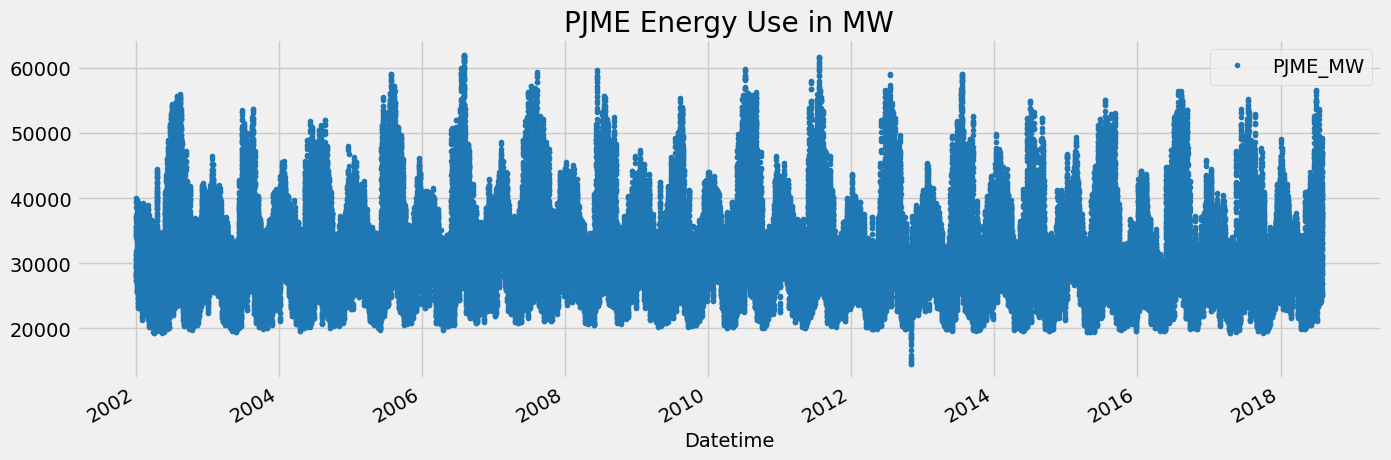

In [73]:
df.plot(style='.',
       figsize=(15, 5),
       color= color_pal[0],
       title='PJME Energy Use in MW')
plt.show()

##Train / Test Split

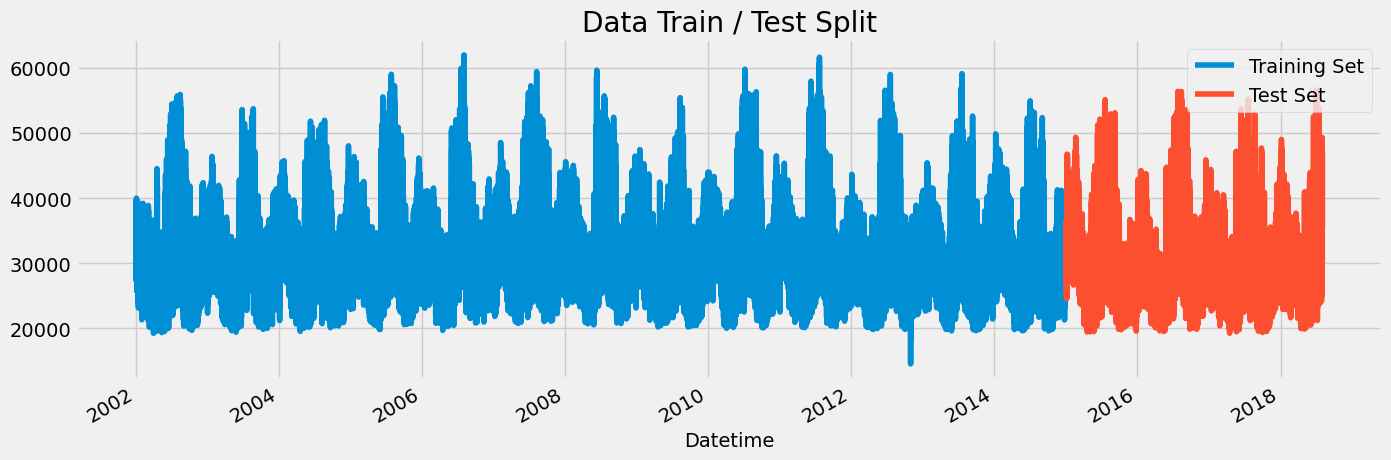

In [74]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train / Test Split')
test.plot(ax=ax, label='Test Set')
#ax.axvline('01-01-2015', color='black', linestyle='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

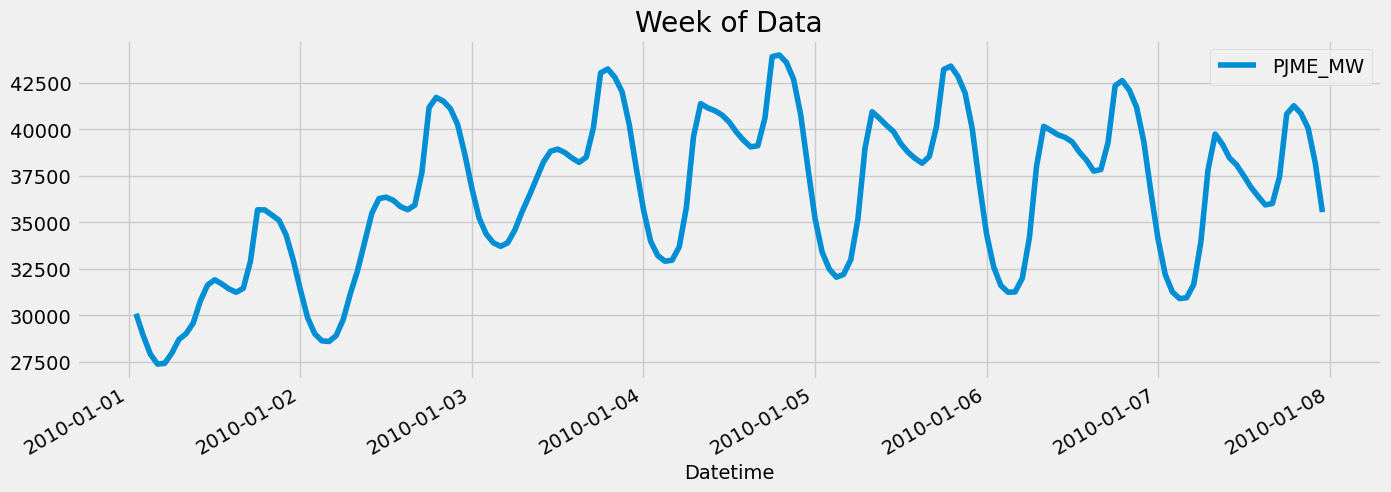

In [75]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize=(15, 5), title='Week of Data')
plt.show()

#Feature Creation

In [76]:
def create_features(df):
    #Create time series features based on time series index 
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)

#Visualize our Feature / Target Relationship

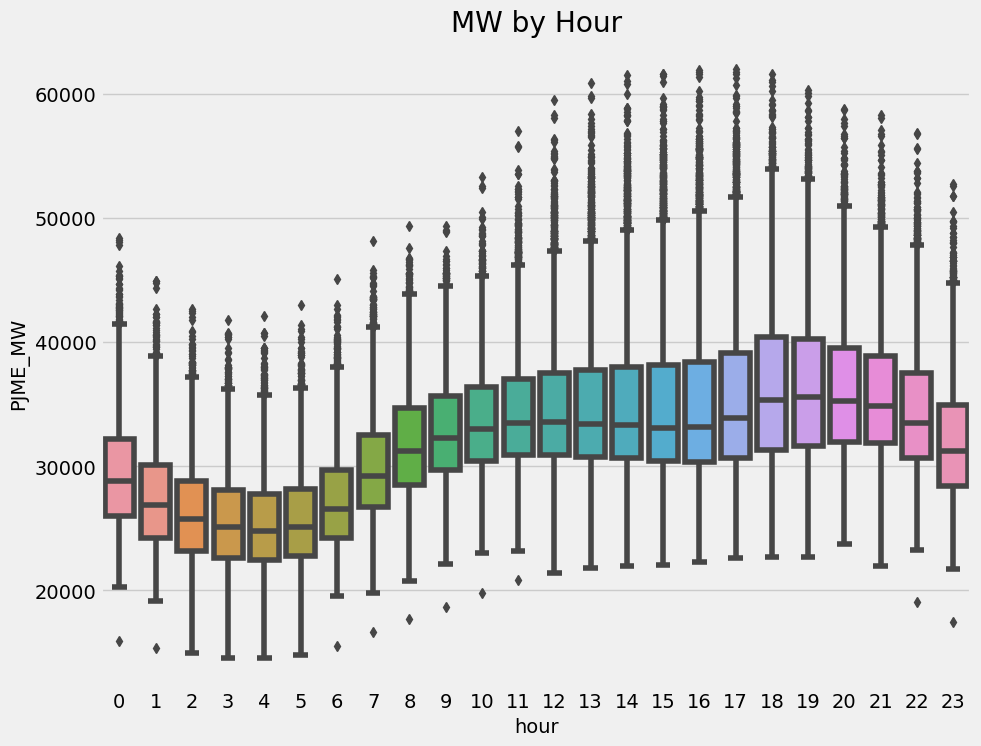

In [77]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

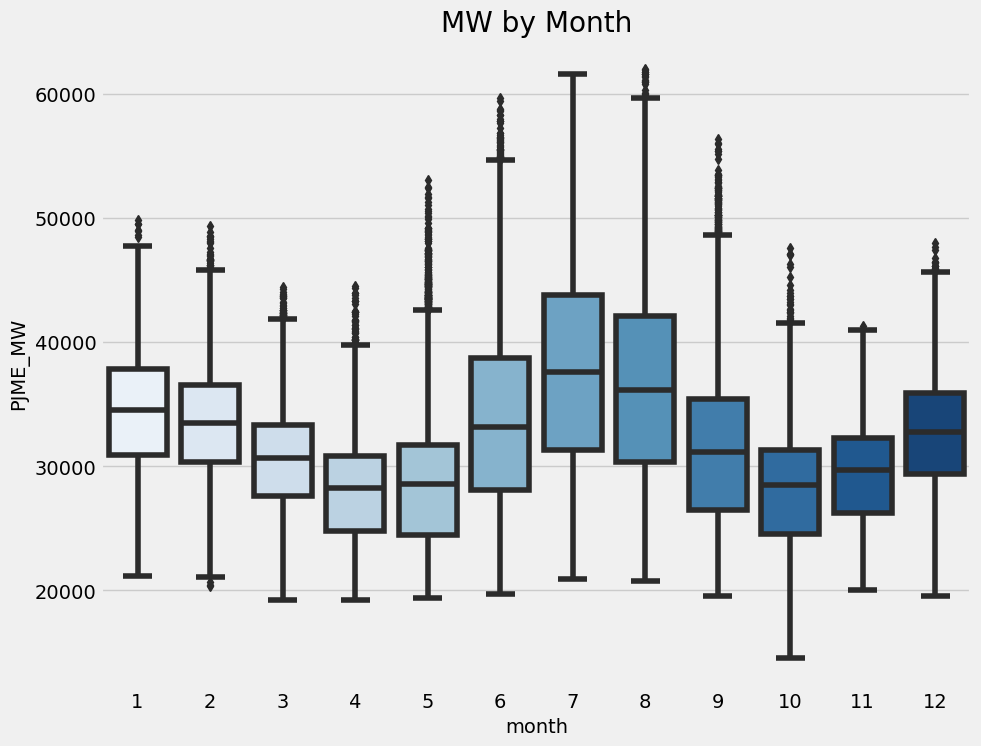

In [78]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

#Create our Model

In [79]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [80]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[100]	validation_0-rmse:12341.93072	validation_1-rmse:11522.06347
[200]	validation_0-rmse:5373.23326	validation_1-rmse:5164.82201
[300]	validation_0-rmse:3377.06238	validation_1-rmse:3829.91316
[400]	validation_0-rmse:2877.98846	validation_1-rmse:3713.12414
[439]	validation_0-rmse:2787.87008	validation_1-rmse:3724.55589


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

#Feature Importance

In [81]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['Importance'])

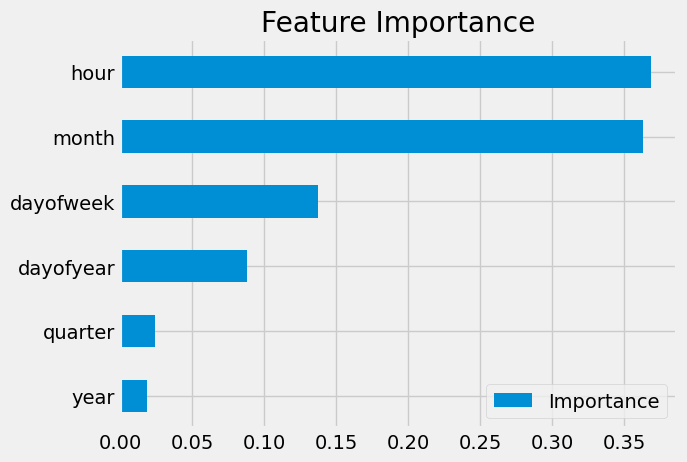

In [82]:
fi.sort_values('Importance').plot(kind='barh', title='Feature Importance')
plt.show()

#Forecast on Test

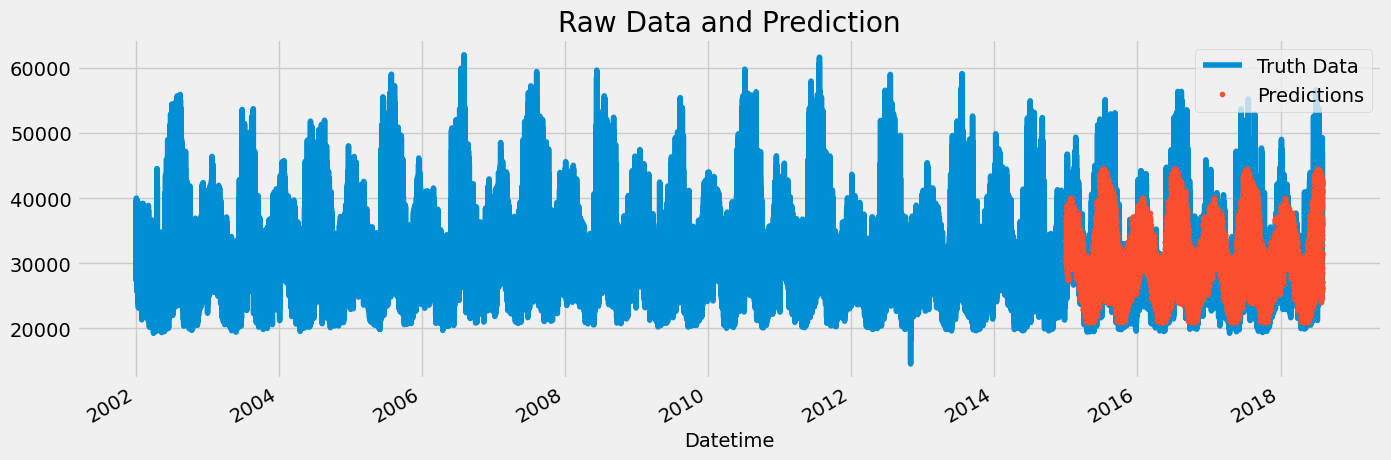

In [83]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

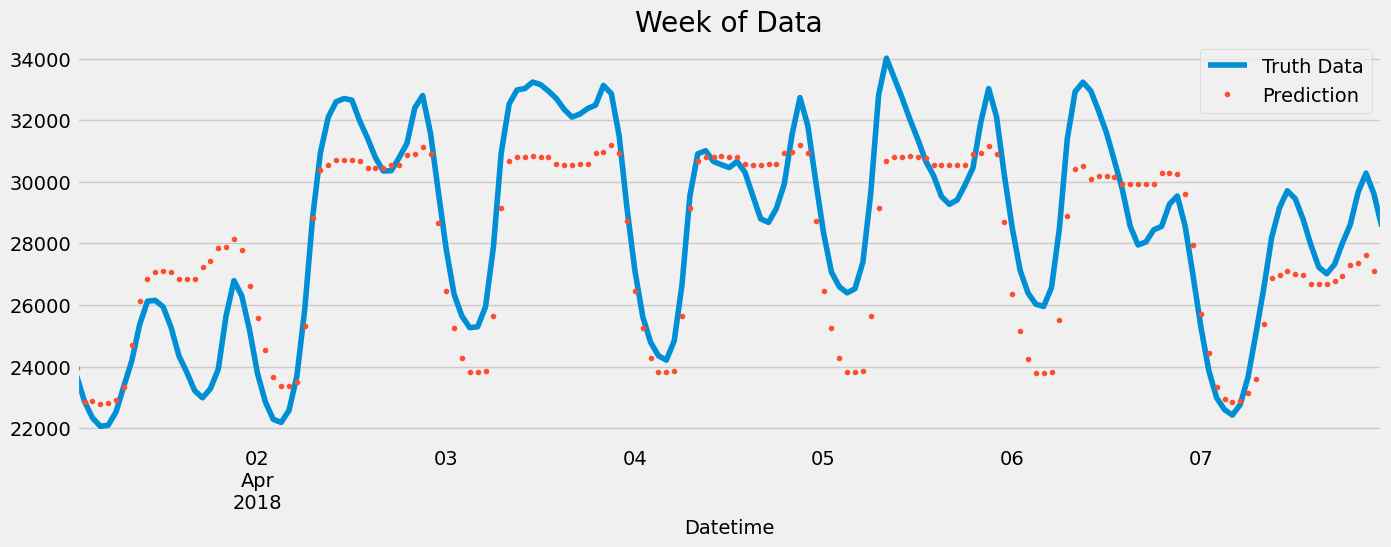

In [84]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW']\
.plot(figsize=(15, 5), title='Week of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction']\
.plot(style='.')
plt.legend(['Truth Data', 'Prediction'])
plt.show()

In [87]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3712.34


#Calculate Error
#Look at the worst and the best predicted day

In [91]:
test['error'] = np.abs(test[TARGET] - test['prediction'])

In [93]:
test['date'] = test.index.date

In [95]:
test.groupby('date')['error'].mean().sort_values(ascending=False).head(5) #peores prediccciones error mas grande

date
2016-08-13    14650.704508
2016-08-14    14538.611247
2016-09-10    12576.863607
2016-09-09    11522.881266
2016-08-12    11510.995850
Name: error, dtype: float64

In [96]:
test.groupby('date')['error'].mean().sort_values(ascending=True).head(5) # mejores predicciones

date
2016-05-01    417.728597
2016-09-27    418.122884
2016-04-04    421.887207
2015-03-10    444.063151
2016-12-08    458.361003
Name: error, dtype: float64

In [97]:
#Mejoras del modelo
#More robust cross validation
#Add more features (weather forecast, holidays)